In [1]:
import numpy as np
import matplotlib.pyplot as plt

class ContinuousSignal:
    def __init__(self, func):
        self.func= func
        
    def shift(self, shift):
        new_signal= ContinuousSignal(lambda t: self.func(t-shift))
        return new_signal
        
    def add(self, other):
        new_signal= ContinuousSignal(lambda t: self.func(t)+ other.func(t))
        return new_signal
    
    def multiply(self, other):
        new_signal= ContinuousSignal(lambda t: self.func(t)* other.func(t))
        return new_signal
    
    def multiply_const_factor(self, scaler):
        new_signal= ContinuousSignal(lambda t: self.func(t)* scaler)
        return new_signal
    
    def plot(self ):
        t = np.linspace(-10, 10, 1000)
        x_t = self.func(t)
        
        plt.figure(figsize=(10, 5))
        plt.plot(t, x_t, label="x(t)", color='blue')
        plt.title('Continuous Signal')
        plt.xlabel('Time (t)')
        plt.ylabel('Amplitude')
        
        plt.xticks(np.arange(-10, 10 + 1, 1))
        plt.axhline( color='red')
        plt.axvline(color='green')
        plt.grid(True)
        plt.show()

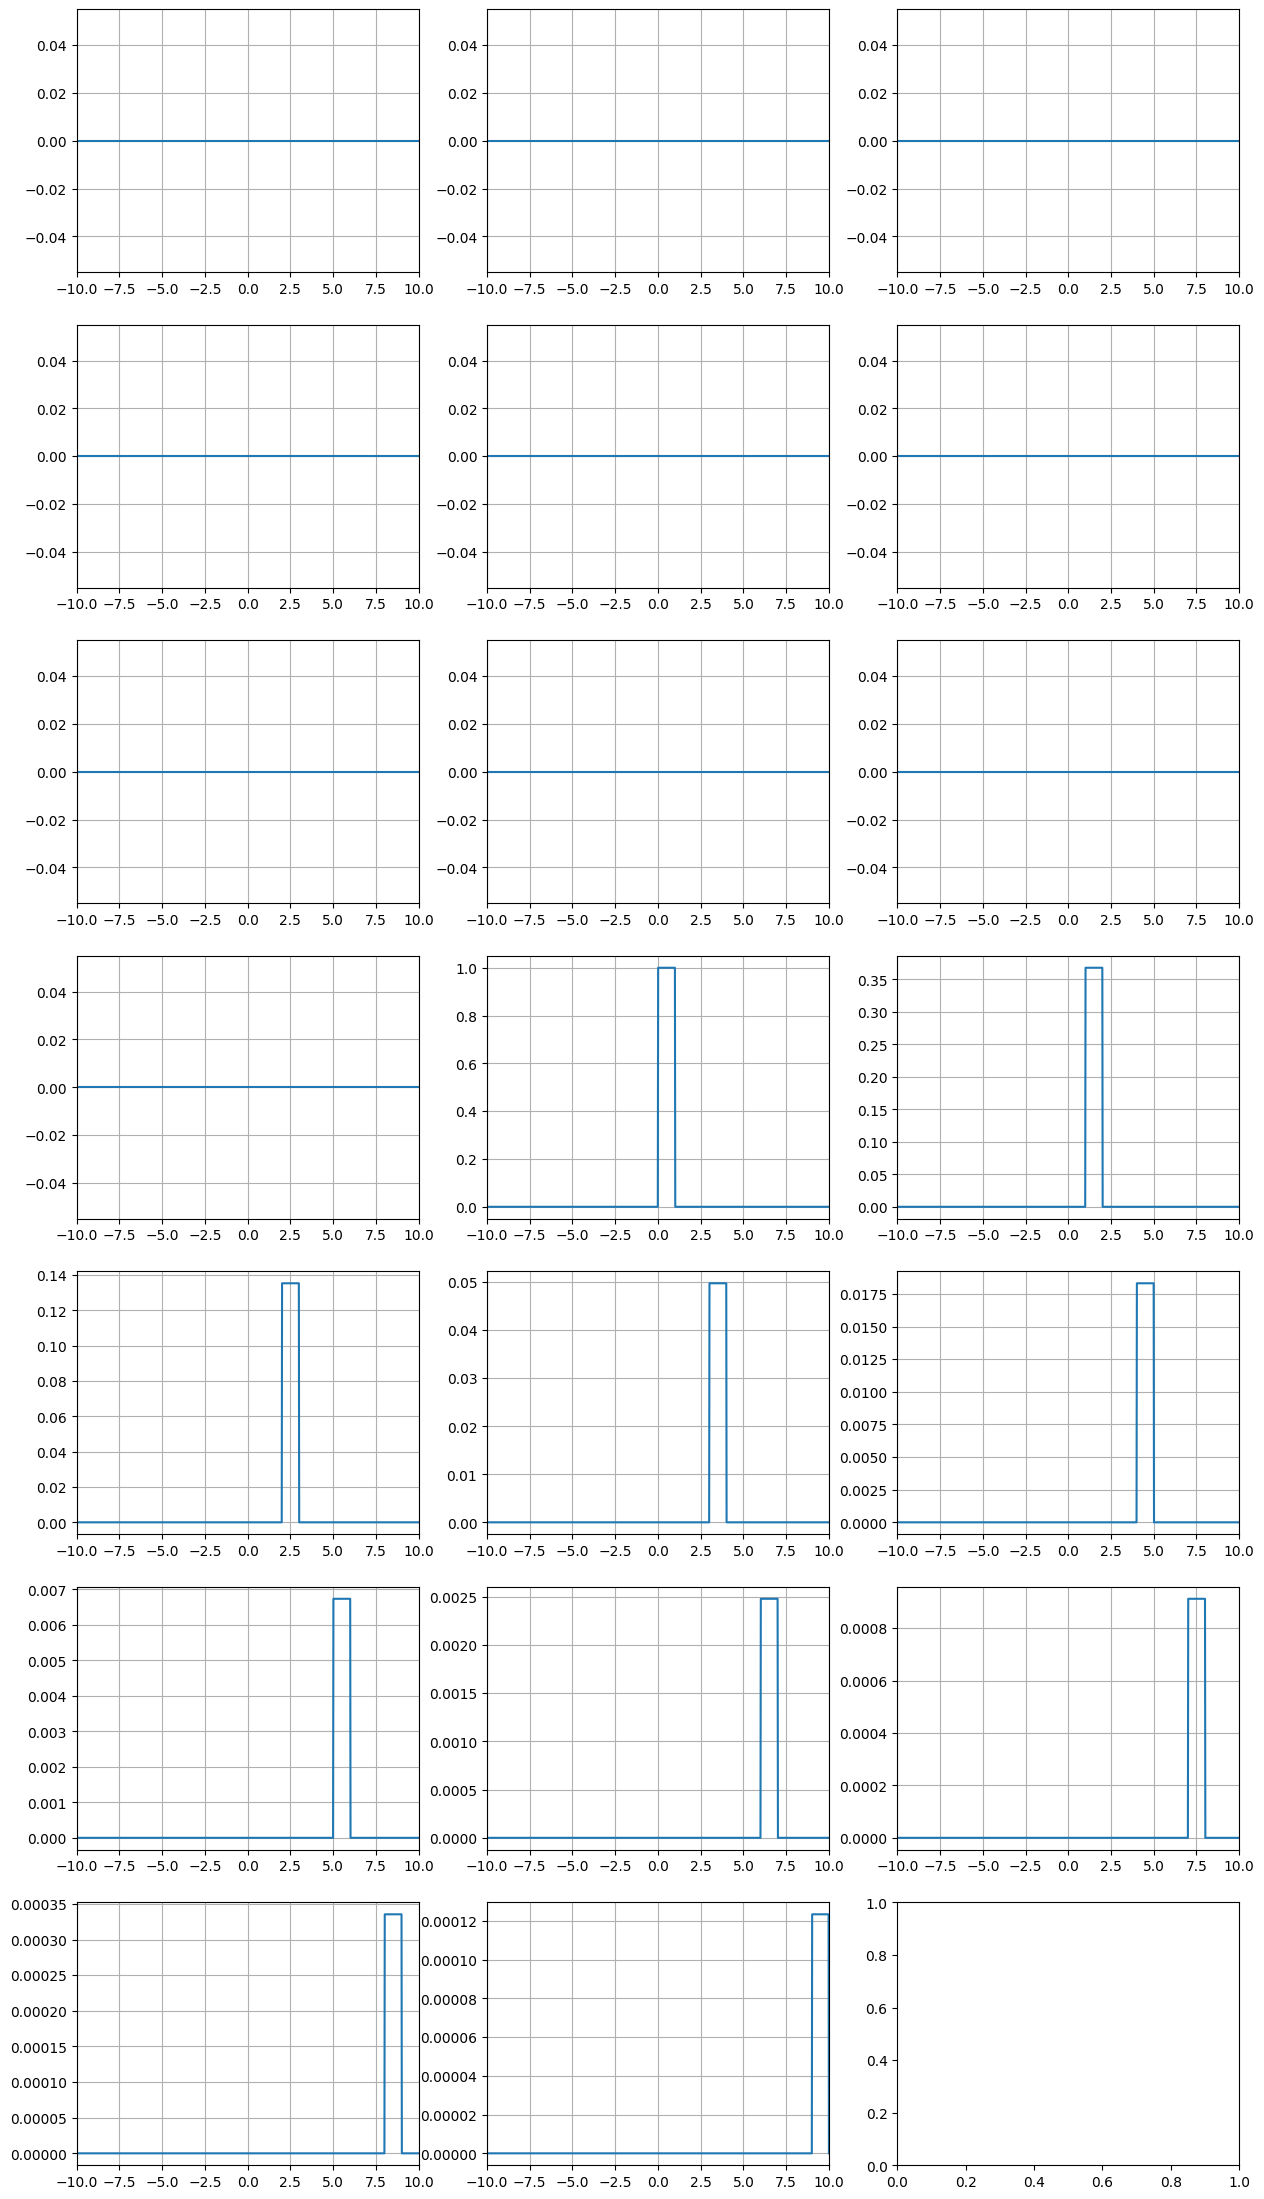

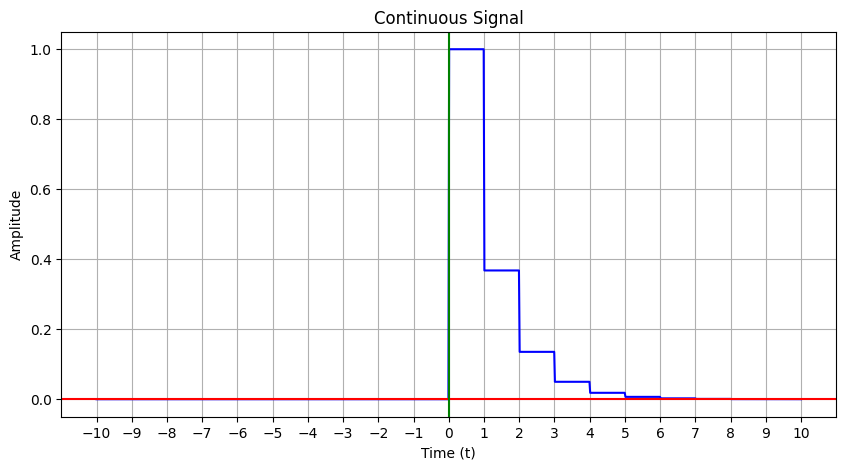

<Figure size 640x480 with 0 Axes>

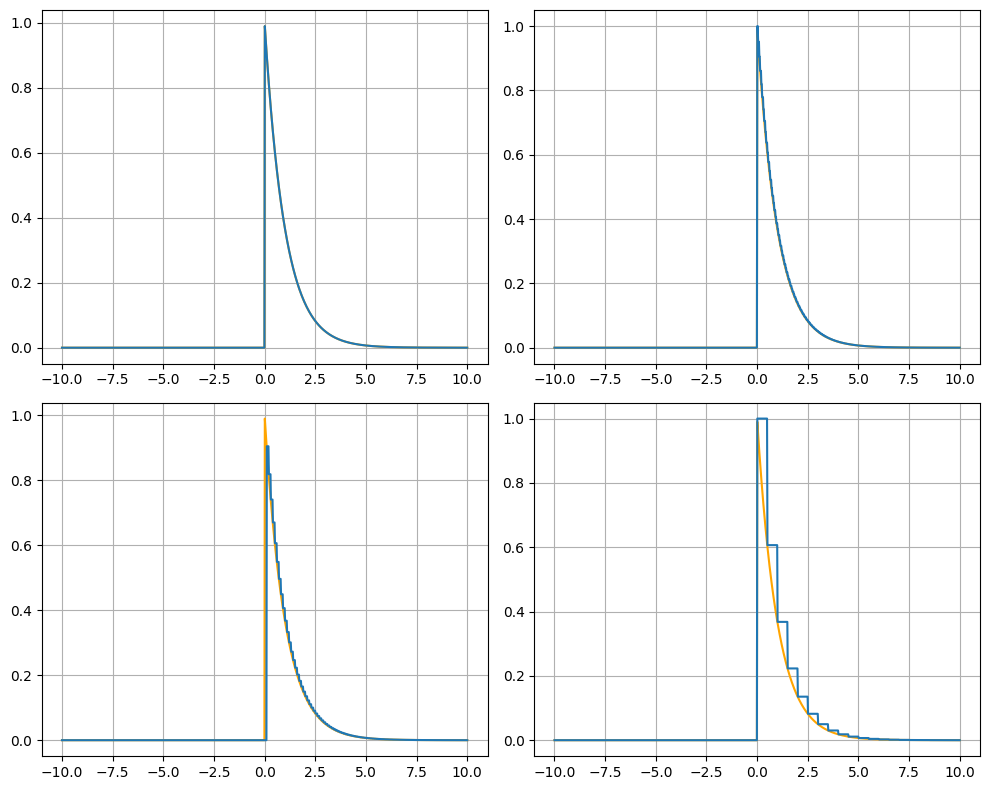

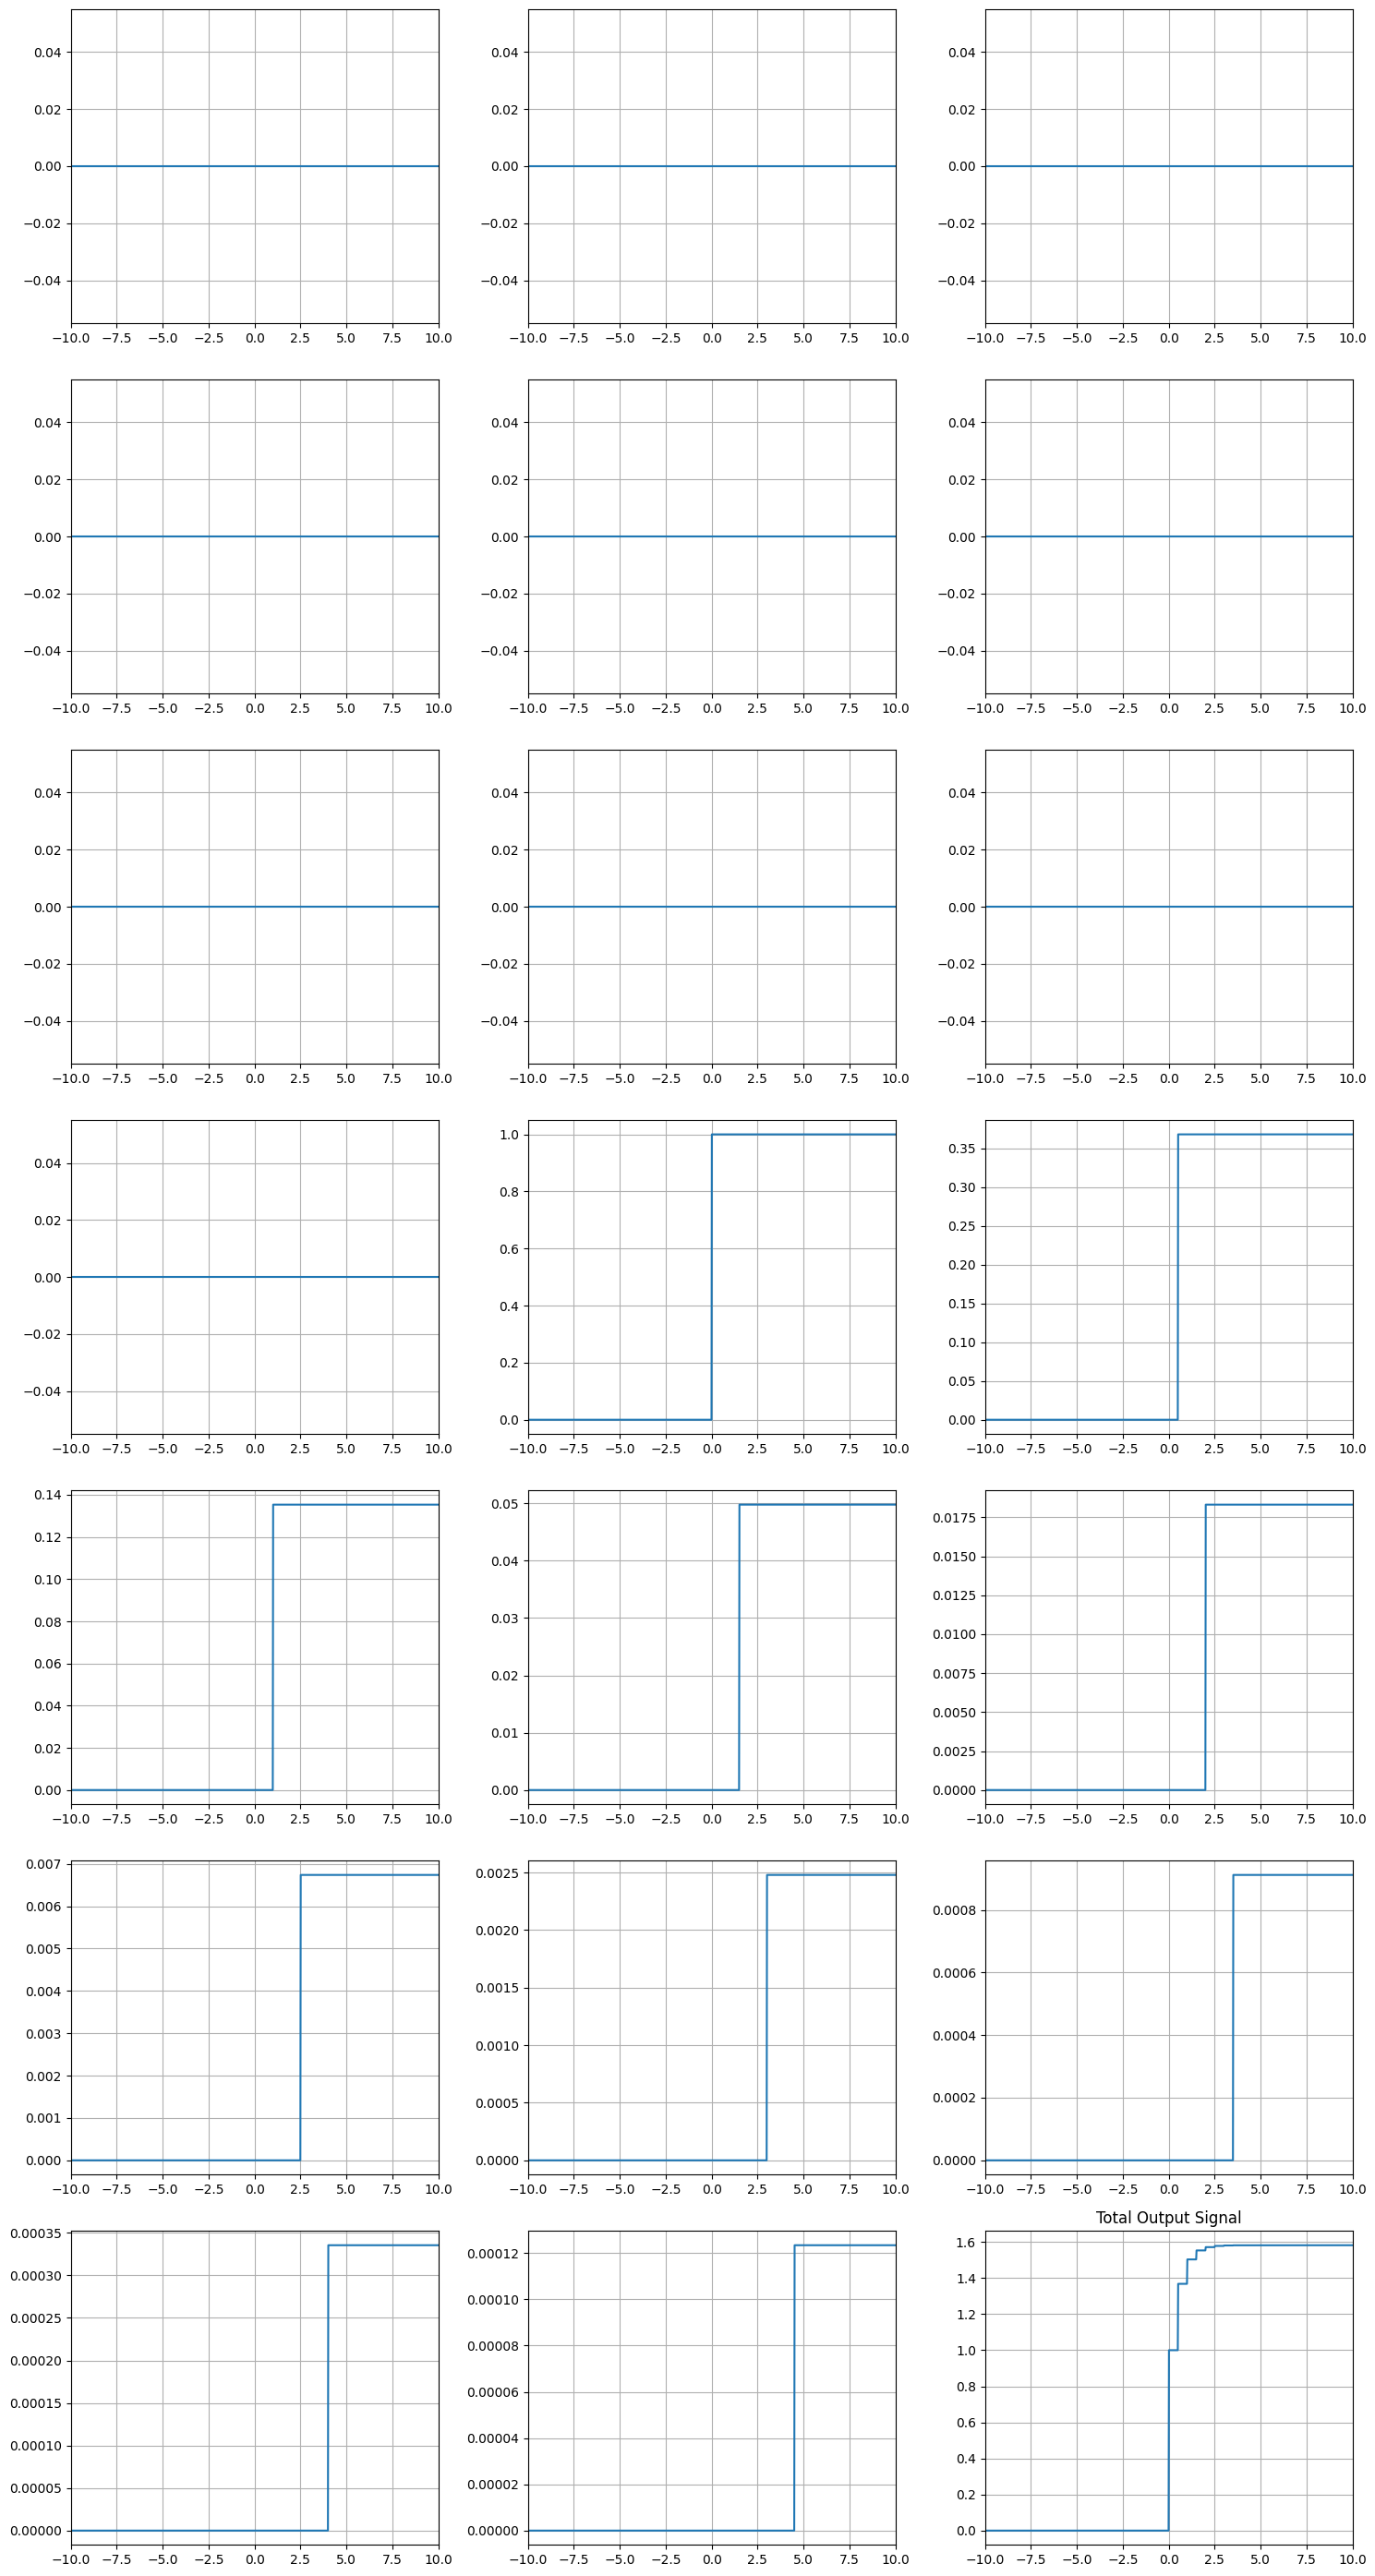

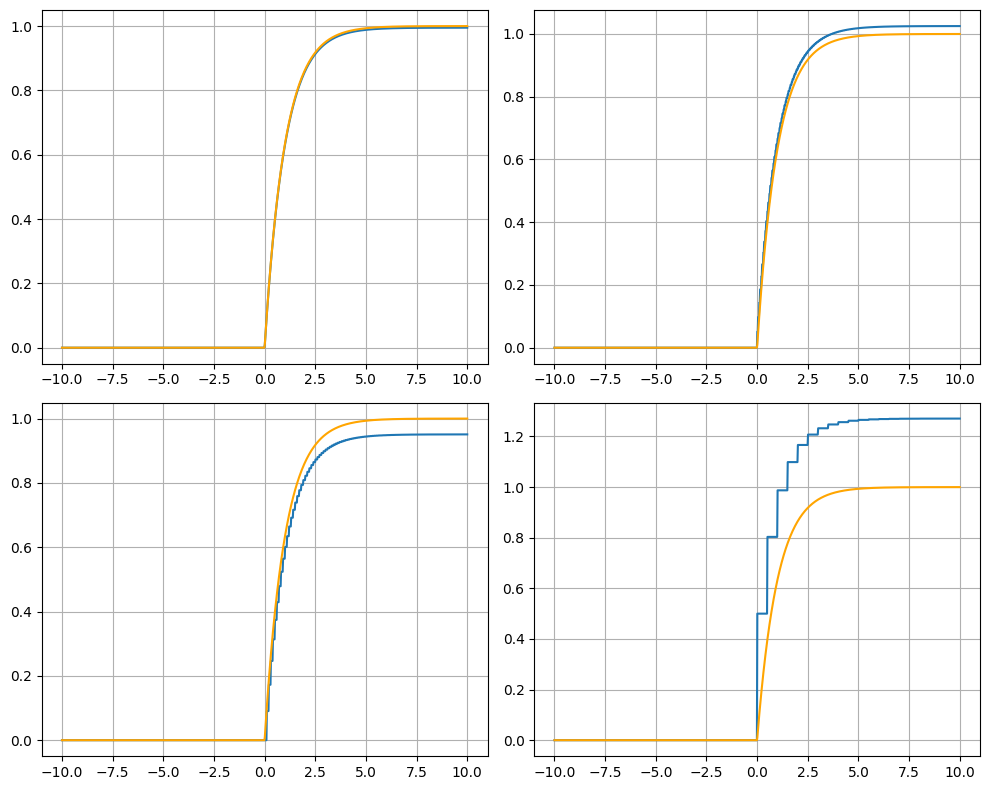

In [62]:
class ContinuousLinearTimeInvariantSystem:
    def __init__(self, impulse_response):
        self.impulse_response = impulse_response

    def linear_combination_of_impulses(self, input_signal, delta):
        values_of_time = np.arange(-10, 10, delta)
        coefficients = input_signal.func(values_of_time) * delta

        impulses = []
        for t in values_of_time:
            impulse_func = lambda tau, t_shift=t: np.where(
                (tau >= t_shift) & (tau < t_shift + delta), 1.0 / delta, 0.0
            )
            impulses.append(ContinuousSignal(impulse_func))

        return impulses, coefficients
    
    def output_approx(self, input_signal, delta):
        impulses, coefficients = self.linear_combination_of_impulses(input_signal, delta)
        output_signal = ContinuousSignal(lambda t: np.zeros_like(t))
        
        for i, impulse in enumerate(impulses):
            # Shift the impulse response by the corresponding time and multiply by the coefficient
            response = self.impulse_response.multiply_const_factor(coefficients[i])
            output_signal = output_signal.add(response)
        
        return output_signal, impulses, coefficients
    
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
input_signal = ContinuousSignal(func=(lambda t: np.exp(-t) * (t >= 0)))
impulse_response = ContinuousSignal(func=(lambda t: np.where(t >= 0, 1, 0)))

lti_system = ContinuousLinearTimeInvariantSystem(impulse_response)
delta = 1
impulses, coefficients = lti_system.linear_combination_of_impulses(input_signal, delta)

num_impulses = len(impulses)
n_cols = 3
n_rows = (num_impulses + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axs = axs.flatten()

reconstructed_signal = ContinuousSignal(lambda t: np.zeros_like(t))

for i, (impulse, coeff) in enumerate(zip(impulses, coefficients)):
    scaled_impulse = impulse.multiply_const_factor(coeff)
    reconstructed_signal = reconstructed_signal.add(scaled_impulse)
    
    t = np.linspace(-10, 10, 1000)
    x_t = scaled_impulse.func(t)
    axs[i].plot(t, x_t)
    axs[i].set_xlim(-10, 10)
    axs[i].grid(True)

reconstructed_signal.plot()

plt.tight_layout()
plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------------------------

delta_values = [0.01, 0.05, 0.1, 0.5]
n_rows = 2
n_cols = 2

# Create subplots for different delta values
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))

for idx, delta in enumerate(delta_values):
    impulses, coefficients = lti_system.linear_combination_of_impulses(input_signal, delta)
    reconstructed_signal = ContinuousSignal(lambda t: np.zeros_like(t))

    for impulse, coeff in zip(impulses, coefficients):
        scaled_impulse = impulse.multiply_const_factor(coeff)
        reconstructed_signal = reconstructed_signal.add(scaled_impulse)

    row, col = divmod(idx, n_cols)
    ax = axs[row, col]
    t = np.linspace(-10, 10, 1000)
    
    ax.plot(t, input_signal.func(t), color='orange')
    
    ax.plot(t, reconstructed_signal.func(t))

    ax.grid(True)

plt.tight_layout()
plt.show()

#------------------------------------------------------------------------------------------------------------------------------------------------------

# Output approximation with impulses
output_signal, impulses, coefficients = lti_system.output_approx(input_signal, 1)

values_of_time = np.linspace(-10, 10, 1000)
num_impulses = len(impulses)

n_cols = 3  
n_rows = (num_impulses + n_cols - 1) // n_cols      

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axs = axs.flatten()

output_sum = ContinuousSignal(lambda t: np.zeros_like(t))

for i in range(num_impulses):
    n = i - (num_impulses // 2) 
        
    impulse = impulses[i]
    coeff = coefficients[i]
    
    response = lti_system.impulse_response.shift(n * delta).multiply_const_factor(coeff)
    
    output_sum = output_sum.add(response)
    
    response_values = response.func(values_of_time)
    
    axs[i].plot(values_of_time, response_values)
    axs[i].set_xlim(-10, 10)
    axs[i].grid(True)
    
output_sum_values = output_sum.func(values_of_time)
axs[num_impulses].plot(values_of_time, output_sum_values, label="Output = Sum")
axs[num_impulses].set_xlim(-10, 10)
axs[num_impulses].grid(True)
axs[num_impulses].set_title("Total Output Signal")

plt.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

reference_func = lambda t: (1 - np.exp(-t)) * (np.where(t >= 0, 1, 0))
    
values_of_time = np.linspace(-10, 10, 1000)

n_rows=2
n_cols=2
    
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))  
    
axs = axs.flatten()
    
for idx, delta in enumerate(delta_values):
    lti_system = ContinuousLinearTimeInvariantSystem(impulse_response)
        
    output_signal, impulses, coefficients = lti_system.output_approx(input_signal, delta)
        
    output_sum = ContinuousSignal(lambda t: np.zeros_like(t))
    for i in range(len(impulses)):
        n = i - (len(impulses) // 2) 
            
        impulse = impulses[i]
        coeff = coefficients[i]
        response = lti_system.impulse_response.shift(n * delta).multiply_const_factor(coeff)
            
        output_sum = output_sum.add(response)
        
    output_sum_values = output_sum.func(values_of_time)
    reference_values = reference_func(values_of_time)
        
    axs[idx].plot(values_of_time, output_sum_values)
    axs[idx].plot(values_of_time, reference_values,color='orange')
        
    axs[idx].grid(True)

plt.tight_layout()
plt.show()

